# Implementation of a CNN (Convolutional Neural Network) Model
### Contributors: Amaritu Shrivastava (21BPS1207) and Armaanjeet Singh Sandhu (21BPS1157)
### Faculty: Dr. Hasmath Farhana A
### Slot: C2 + TC2 + TCC2

## Introduction
Quick, Draw! is an online game developed by Google that challenges players to draw a picture of an object or idea and then uses a neural network AI to guess what the drawings represent. The AI learns from each drawing, improving its ability to guess correctly in the future.

If the AI guesses the sketch (that is, associates it with training set items of the same label), a check mark shows up and the gameplay moves on to the next object. At the end, the results are displayed:
<p><br></p>
<img src="https://s3.amazonaws.com/nonwebstorage/Screenshot+from+2018-09-26+22-44-21.png" alt="drawing1" width="600"/>
<p><br></p>
<img src="https://s3.amazonaws.com/nonwebstorage/Screenshot+from+2018-09-26+22-45-21.png" alt="drawing1" width="600"/>

## Training Images
We can look at a few sketches and then see what the training data contains overall. Here, we've used a variation of Inversion's 'Getting Started' kernel.

In [ ]:
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline

Here's what the training data looks like. This data frame is actually a concatenation of two rows from each of 6 csv files in the training set.

In [ ]:
fnames = glob('../input/train_simplified/*.csv')
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames[0:8]:
    first = pd.read_csv(f, nrows=10) # make sure we get a recognized drawing
    first = first[first.recognized==True].head(2)
    drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[0, 29, 48, 168, 169, 144, 124, 121, 71, 3],...",6516695600463872,True,2017-03-12 19:14:45.275810,traffic light
1,UA,"[[[26, 24, 9, 0, 1, 27, 60, 102, 105, 120, 134...",5126103083515904,True,2017-03-17 15:35:33.751320,traffic light
2,AU,"[[[253, 216], [0, 87]], [[253, 255, 250, 243, ...",4944687414640640,True,2017-03-30 00:36:22.096160,rhinoceros
3,GB,"[[[148, 192, 219, 242, 254, 251, 255, 255, 225...",5103733769764864,True,2017-03-12 09:48:13.983520,rhinoceros
4,US,"[[[18, 12, 0, 11, 115, 157, 181, 221, 242, 253...",4897919444451328,True,2017-01-24 22:38:33.588730,bed
5,RU,"[[[24, 22, 23, 12, 51, 87, 176, 221, 221, 241,...",6744954825080832,True,2017-03-02 19:28:20.683890,bed
6,HR,"[[[0, 3, 7, 12, 52, 81, 210, 249, 252, 255, 25...",6551252072660992,True,2017-01-24 14:32:36.266040,school bus
7,US,"[[[9, 29, 36, 54, 72, 98, 184, 206], [56, 56, ...",6286248643657728,True,2017-03-15 21:48:29.097030,school bus
8,US,"[[[4, 0, 2, 27, 39, 93, 196, 206, 210, 222, 24...",5459265223393280,True,2017-03-03 18:48:44.630040,van
9,DZ,"[[[154, 66, 48, 51, 26, 9, 1, 0, 7, 14, 84, 12...",5575928799297536,True,2017-03-27 18:27:04.576080,van


In [ ]:
evens = range(0,12,2)
odds = range(1,13, 2)
df1 = draw_df[draw_df.index.isin(evens)]
df2 = draw_df[draw_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]

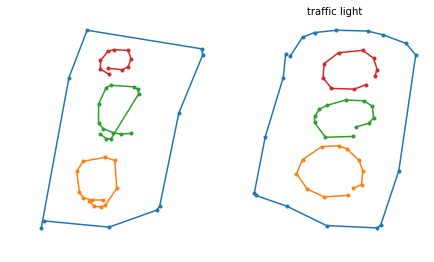

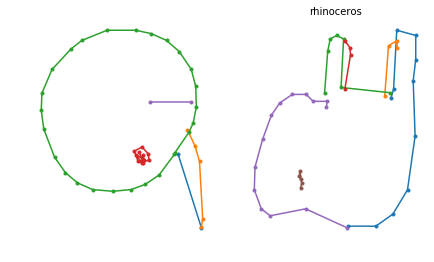

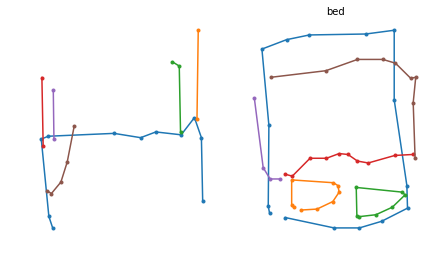

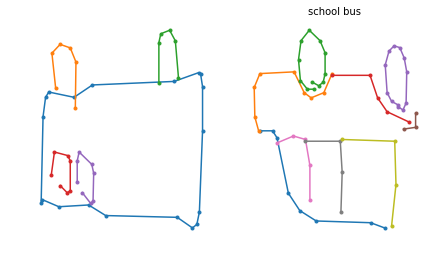

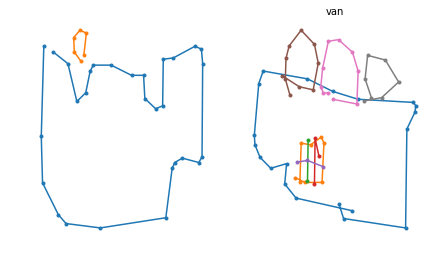

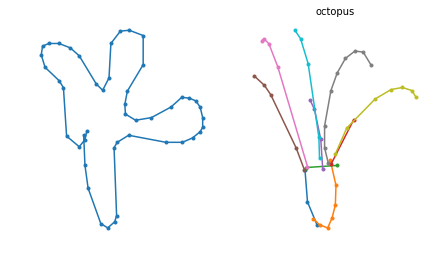

In [ ]:
labels = df2.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(7,4))
    
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')

    for x,y, in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)

    plt.show()  

## The Quick, Draw! Data Repository
The [GitHub Repository](https://github.com/googlecreativelab/quickdraw-dataset) leads to the data in several formats, including Numpy bitmap files. Each file in the dataset covers a specific type of sketch and is in the shape of a long 1d array. Here are a few:

In [ ]:
# # commented out to save memory
# import urllib

# LABELS = np.array(['baseball', 'bowtie', 'clock', 'hand', 'hat'])
# for b in LABELS:
#     url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{}.npy".format(b)
#     urllib.request.urlretrieve(url, "{}.npy".format(b))
#     nb = np.load("{}.npy".format(b))
#     print("\n Class '{0}' has {1} examples of {2}x{2} images".format(b, nb.shape[0], int(nb.shape[1]**0.5)))

## Building a CNN image classifier

In [ ]:
%reset -f 

In [ ]:
#%% import
import os
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
#%% set label dictionary and params
classfiles = os.listdir('../input/train_simplified/')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} #adds underscores

num_classes = 340    #340 max 
imheight, imwidth = 32, 32  
ims_per_class = 2000  #max?

In [ ]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=257)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/257.

#%% get train arrays
train_grand = []
class_paths = glob('../input/train_simplified/*.csv')
for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train




  0%|          | 0/340 [00:00<?, ?it/s]


  0%|          | 1/340 [00:01<09:10,  1.63s/it]


  1%|          | 2/340 [00:03<09:43,  1.73s/it]


  1%|          | 3/340 [00:05<09:12,  1.64s/it]


  1%|          | 4/340 [00:06<09:30,  1.70s/it]


  1%|▏         | 5/340 [00:08<09:22,  1.68s/it]


  2%|▏         | 6/340 [00:10<09:18,  1.67s/it]


  2%|▏         | 7/340 [00:11<09:27,  1.70s/it]


  2%|▏         | 8/340 [00:13<09:10,  1.66s/it]


  3%|▎         | 9/340 [00:15<09:51,  1.79s/it]


  3%|▎         | 10/340 [00:17<09:15,  1.68s/it]


  3%|▎         | 11/340 [00:18<09:21,  1.71s/it]


  4%|▎         | 12/340 [00:20<08:39,  1.58s/it]


  4%|▍         | 13/340 [00:21<08:57,  1.64s/it]


  4%|▍         | 14/340 [00:23<08:38,  1.59s/it]


  4%|▍         | 15/340 [00:25<09:31,  1.76s/it]


  5%|▍         | 16/340 [00:26<08:56,  1.66s/it]


  5%|▌         | 17/340 [00:29<09:44,  1.81s/it]


  5%|▌         | 18/340 [00:30<09:10,  1.71s/it]


  6%|▌         | 19/340 [00:32<09:03,  1.69s/i

In [ ]:
# memory-friendly alternative to train_test_split?
valfrac = 0.1
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

(612000, 340) 
 (612000, 32, 32, 1) 
 (68000, 340) 
 (68000, 32, 32, 1)


### CNN Architecture

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(4, 4), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 680)               392360    
__________

In [ ]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=5) 
callbacks = [reduceLROnPlat, earlystop]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

model.fit(x=X_train, y=y_train,
          batch_size = 34,
          epochs = 24,
          validation_data = (X_val, y_val),
          callbacks = callbacks,
          verbose = 1)

Train on 612000 samples, validate on 68000 samples
Epoch 1/24
612000/612000 [==============================] - 93s 152us/step - loss: 3.8078 - acc: 0.1851 - top_3_accuracy: 0.3401 - val_loss: 2.7320 - val_acc: 0.3805 - val_top_3_accuracy: 0.5923
Epoch 2/24
612000/612000 [==============================] - 85s 139us/step - loss: 3.1406 - acc: 0.2826 - top_3_accuracy: 0.4793 - val_loss: 2.5131 - val_acc: 0.4240 - val_top_3_accuracy: 0.6388
Epoch 3/24
612000/612000 [==============================] - 90s 147us/step - loss: 2.9921 - acc: 0.3092 - top_3_accuracy: 0.5123 - val_loss: 2.3960 - val_acc: 0.4410 - val_top_3_accuracy: 0.6569
Epoch 4/24
612000/612000 [==============================] - 91s 149us/step - loss: 2.9224 - acc: 0.3215 - top_3_accuracy: 0.5272 - val_loss: 2.3318 - val_acc: 0.4499 - val_top_3_accuracy: 0.6660
Epoch 5/24
612000/612000 [==============================] - 90s 147us/step - loss: 2.8817 - acc: 0.3295 - top_3_accuracy: 0.5366 - val_loss: 2.3404 - val_acc: 0.4559 - v

## Predicting on the Test data
The CNN performs fairly well on the validation data, even with a basic model and limited training data. Next, we generate predictions on the test set and submit.

In [ ]:
#%% get test set
ttvlist = []
reader = pd.read_csv('../input/test_simplified.csv', index_col=['key_id'],
    chunksize=2048)
for chunk in tqdm(reader, total=55):
    imagebag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    testarray = np.array(imagebag.compute())
    testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
    testpreds = model.predict(testarray, verbose=0)
    ttvs = np.argsort(-testpreds)[:, 0:3]  # top 3
    ttvlist.append(ttvs)
    
ttvarray = np.concatenate(ttvlist)




  0%|          | 0/55 [00:00<?, ?it/s]


  2%|▏         | 1/55 [00:02<01:52,  2.08s/it]


  4%|▎         | 2/55 [00:05<02:04,  2.35s/it]


  5%|▌         | 3/55 [00:07<01:56,  2.24s/it]


  7%|▋         | 4/55 [00:09<01:51,  2.19s/it]


  9%|▉         | 5/55 [00:11<01:47,  2.15s/it]


 11%|█         | 6/55 [00:13<01:43,  2.12s/it]


 13%|█▎        | 7/55 [00:15<01:45,  2.20s/it]


 15%|█▍        | 8/55 [00:17<01:41,  2.16s/it]


 16%|█▋        | 9/55 [00:19<01:37,  2.13s/it]


 18%|█▊        | 10/55 [00:21<01:34,  2.10s/it]


 20%|██        | 11/55 [00:23<01:31,  2.07s/it]


 22%|██▏       | 12/55 [00:26<01:32,  2.15s/it]


 24%|██▎       | 13/55 [00:28<01:28,  2.12s/it]


 25%|██▌       | 14/55 [00:30<01:26,  2.11s/it]


 27%|██▋       | 15/55 [00:32<01:23,  2.09s/it]


 29%|██▉       | 16/55 [00:34<01:24,  2.16s/it]


 31%|███       | 17/55 [00:37<01:28,  2.34s/it]


 33%|███▎      | 18/55 [00:39<01:24,  2.28s/it]


 35%|███▍      | 19/55 [00:41<01:19,  2.21s/it]


 36%|███▋      

In [ ]:
preds_df = pd.DataFrame({'first': ttvarray[:,0], 'second': ttvarray[:,1], 'third': ttvarray[:,2]})
preds_df = preds_df.replace(numstonames)
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv('../input/sample_submission.csv', index_col=['key_id'])
sub['word'] = preds_df.words.values
sub.to_csv('subcnn_small.csv')
sub.head()

,word
key_id,
9000003627287624,radio motorbike stereo
9000010688666847,sandwich hamburger hot_dog
9000023642890129,The_Great_Wall_of_China castle fence
9000038588854897,mountain tent triangle
9000052667981386,campfire rabbit waterslide


 A full version with 6000 images per class at 28x28 gets just under 0.60 on the public LB.  

In [ ]:
import sys

ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not 
    x.startswith('_') and x not in sys.modules and x 
    not in ipython_vars], key=lambda x: x[1], reverse=True)

[('preds_df', 30556698),
 ('sub', 9892769),
 ('ttvarray', 2692888),
 ('testpreds', 2185632),
 ('chunk', 1053432),
 ('labelarray', 16112),
 ('numstonames', 9320),
 ('class_paths', 3104),
 ('Sequential', 3096),
 ('classfiles', 2896),
 ('Dense', 2000),
 ('Dropout', 2000),
 ('Flatten', 2000),
 ('MaxPooling2D', 2000),
 ('EarlyStopping', 1464),
 ('ReduceLROnPlateau', 1464),
 ('ModelCheckpoint', 1056),
 ('Conv2D', 888),
 ('ttvlist', 528),
 ('X_train', 144),
 ('X_val', 144),
 ('testarray', 144),
 ('draw_it', 136),
 ('top_3_accuracy', 136),
 ('top_k_categorical_accuracy', 136),
 ('ttvs', 112),
 ('y_train', 112),
 ('y_val', 112),
 ('c', 83),
 ('Image', 80),
 ('ImageDraw', 80),
 ('bag', 80),
 ('callbacks', 80),
 ('keras', 80),
 ('np', 80),
 ('pd', 80),
 ('tf', 80),
 ('earlystop', 56),
 ('imagebag', 56),
 ('model', 56),
 ('reader', 56),
 ('reduceLROnPlat', 56),
 ('cutpt', 28),
 ('i', 28),
 ('imheight', 28),
 ('ims_per_class', 28),
 ('imwidth', 28),
 ('num_classes', 28),
 ('valfrac', 24)]